**Ιωάννης Καπετανγεώργης**

**Αριθμός μητρώου: 1115201800061** 

Πριν από την εκτέλεση οποιουδήποτε από τα δύο κελιά (τελικό μοντέλο ή κώδικα δοκιμών) πρέπει να εκτελεστεί το παρακάτω κελί έτσι ώστε να γίνουν import όλα όσα χρησιμοποιούνται σε αυτά.

In [ ]:
!pip install emoji --upgrade
!pip install tweet-preprocessor
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline 
import string
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import preprocessor as p
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

Στο παρακάτω κελί υπάρχουν τα path των train set και validation set από όπου διαβάζονται τα δεδομένα.

Για την αντικατάσταση του validation set από το test set κατά την διόρθωση της εργασίας αρκεί να αλλάξει το path του validation set.
Δηλαδή αλλάζουμε την μεταβλητή validation_set_location αντικαθιστόντας το υπάρχον path με το αντίστοιχο path του test set.

In [ ]:
train_set_location = r'vaccine_train_set.csv'
validation_set_location = r'vaccine_validation_set.csv'

# ΤΕΛΙΚΟ ΜΟΝΤΕΛΟ

Στο παρακάτω κελί παραθέτω την υλοποίηση μου για το τελικό βέλτιστο μοντέλο softmax classifier.

Η διαδικασία που ακολουθείται για την παραγωγή του μοντέλου είναι η εξής:    
  - Αρχικά εφαρμόζεται προεπεξεργασία των δεδομένων. Πιο συγκεκριμένα εφαρμόζεται:     
    - Μετατροπή του κειμένου σε lower case
    - Αφαίρεση links, mentions και αριθμών (μέσω της συνάρτησης clean_tweets)
    - Αντικατάσταση των emojis με το αντίστοιχο text (μέσω της συνάρτησης removeEmojis)
    - Αφαίρεση συμβόλων και σημείων στίξης (μέσω της συνάρτησης removePunciation)
  - Στην συνέχεια μετατρέπουμε σε 2 λίστες τα tweets του train set και τα αντίστοιχα labels των tweets (X_train και y_train αντίστοιχα). Το ίδιο κάνουμε και για tweets/labels του validation set (X_valdation και y_validation).
  - Αρχικοποιούμε τον TF-IDF Vectorizer με τις κατάλληλες παραμέτρους, κάνουμε fit_tranform για το train set και στην συνέχεια transform για το validation set. Έτσι προκύπτουν οι αναπαραστάσεις τόσο για το test όσο και για το validation set. Οι παράμετροι με τις οποίες αρχικοποιείται ο TF-IDF είναι:
    - n_gram = (1,3)
    - max_features = 100.000 
    - οι υπόλοιπες παράμετροι έχουν την default τιμή τους
  - Εφαρμόζουμε decomposition μέσω του TruncatedSVD για την μείωση των features που έχουν προκύψει για τις αναπαραστάσεις του train και του validation set. O τελικός αριθμός των features που θα προκύψουν από τον SVD είναι 600 (n_components = 600).
  - Αρχικοποιούμε με τις κατάλληλες παραμέτρους τον softmax, τον εκπαιδεύουμε με το train set (fit) και τελικά τον δοκιμάζουμε στο validation set κάνοντας predict. Για τον softmax χρησιμοποιούμε Logistic Regression με τις εξής παραμέτρους:    
    - multi_class='multinomial' (έτσι ώστε να προκύψει ο softmax)
    - solver ='newton-cg'
    - C = 3
    - max_iter=1000
  - Τέλος αξιολογούμε το μοντέλο με βάση τα prediction που έκανε ο softmax για το validation set. Για την αξιολόγηση υπολογίζονται και εκτυπώνονται τα εξής:
    - accuracy
    - f1_score
    - precision 
    - recall 
    - confusion matrix
    - learning curves 


Softmax Regression using vectorizer: TF-IDF
 Accuracy: 72.92%
 f1 score: 72.62%
 Precision: 73.39%
 Recall: 72.92%


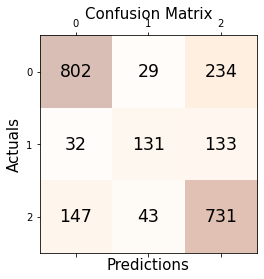

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1065
           1       0.65      0.44      0.53       296
           2       0.67      0.79      0.72       921

    accuracy                           0.73      2282
   macro avg       0.71      0.66      0.68      2282
weighted avg       0.73      0.73      0.73      2282



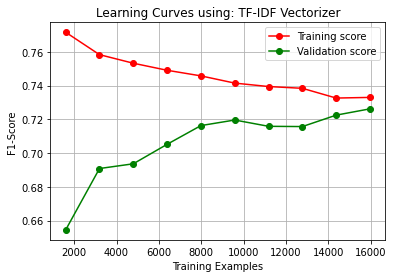

In [ ]:
trainSet = pd.read_csv(train_set_location,index_col=0)  # read csv file and store it to a dataframe
validationSet = pd.read_csv(validation_set_location,index_col=0)  # read csv file and store it to a dataframe

trainSet = trainSet.dropna()  # remove empty tweets (there are no empty tweets in the given dataset)
validationSet = validationSet.dropna()

p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.NUMBER) # set tweet-preprocessor to remove urls, mentions and numbers

def clean_tweets(data,column):  # function that removes urls, mentions and numbers from all the tweets of the given dataframe
  for i,v in enumerate(data[column]): # for every tweet
      data.loc[i,column] = p.clean(v)
  return data

tweet_tokenizer = TweetTokenizer()  # initialize tweet tokenizer

punctuations = list(string.punctuation)
punctuations = punctuations + ['–','::','“','’','”','‘']
punctuations.remove('#')
punctuations.remove('!')
punctuations.remove('?')

def removeEmojis(text):  # function that converts emojis to the equivalent text
    text = emoji.demojize(text) # remove emojis
    return str(text) 

def removePuncutation(text): # remove punctuation from the given text
    text = text.replace("-","")
    splitted = tweet_tokenizer.tokenize(text) # split the tweet into tokens
    new_text = []
    for word in splitted: # for every token
      if word not in punctuations:  # keep it only if it is not a punctuation
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def clean(text):  # clean the given tweet
    text = text.lower() # convert all letters in to lowercase
    text = removeEmojis(text) # convert all emojis to the equivelent text
    text = removePuncutation(text)  # remove all punctuation 
    return text

def cleanText(data,column): # apply clean function to every tweet of the given dataframe
  data[column] = data[column].apply(clean)
  return data

# CLEAN_ULR_MENTIONS_NUMBERS
trainSet = clean_tweets(trainSet,'tweet') # remove urls, mentions, numbers from all the tweets in the train set
validationSet = clean_tweets(validationSet,'tweet') # remove urls, mentions, numbers from all the tweets in the validation set
# CLEAN_EMOJIS CLEAN_PUNCUATIONS CONVERT_TO_LOWERCASE
trainSet = cleanText(trainSet,'tweet')  # clean the tweets of the train set 
validationSet = cleanText(validationSet,'tweet')  # clean the tweets of the validation set

X_train = list(trainSet['tweet']) # convert the tweets of the train set into a list
y_train = list(trainSet['label']) # convert the labels of the train set into a list

X_validation = list(validationSet['tweet']) # convert the tweets of the validation set into a list
y_validation = list(validationSet['label']) # convert the labels of the validation set into a list

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),max_features=100000) #initialize the TfidfVectorizer
trainSet_transformed_tfidf = tfidf_vectorizer.fit_transform(X_train)  # run the vectorizer for all the tweets of the train set
validationSet_transformed_tfidf = tfidf_vectorizer.transform(X_validation)  # transform the tweets of the validation set

svd_tfidf = TruncatedSVD(n_components=600)  # initialize SVD
trainSet_transformed_tfidf = svd_tfidf.fit_transform(trainSet_transformed_tfidf)  # run SVD for the train set in order to minimize the number features
validationSet_transformed_tfidf = svd_tfidf.transform(validationSet_transformed_tfidf)  # run SVD for the validation set in order to minimize the number features

softmax_classifier_tfidf = LogisticRegression(multi_class='multinomial', solver ='newton-cg',C = 3, max_iter=1000)  # initialize Softmax Regression
softmax_classifier_tfidf.fit(trainSet_transformed_tfidf, y_train) # train softmax using the train set 
predicted_y_tfidf = softmax_classifier_tfidf.predict(validationSet_transformed_tfidf)  # predict the labels of the validation set 


def find_learning_curves(model,train_set,train_labels,validation_set,validation_label,modelName):  # function that creates the learning curves for the given model 
  sizes = (np.linspace(0.1, 1.0, 10)*(train_set.shape[0])).astype(int) # the size of the train set for every iteration
  validation_scores = []
  train_scores = []
  validation_mse = []
  train_mse = []
  for size in sizes:   # for every size of the training set
    new_train_set = train_set[:size]   # keep only the first (size) tweets of the train set in order to train the model
    new_train_label = train_labels[:size]   # keep only the first (size) labels of the train set
    model.fit(new_train_set,new_train_label)   # train the model with the current train size
    predictions_train = model.predict(new_train_set)   # test the model for the current train set (training score)
    f1_score_train = f1_score(new_train_label,predictions_train,average='weighted')  # compute the training score using f1 metric
    mse_train = mean_squared_error(new_train_label,predictions_train)
    train_scores.append(f1_score_train)  # store the training score
    train_mse.append(mse_train)
    predictions_validation = model.predict(validation_set)     # test the model for the whole validation set (validation score)
    f1_score_validation = f1_score(validation_label,predictions_validation,average='weighted')    # compute the validation score using f1 metric
    mse_validation = mean_squared_error(validation_label,predictions_validation)
    validation_scores.append(f1_score_validation)   # store the validation score
    validation_mse.append(mse_validation)
  # After all the iterations finish, plot the learning curves
  plt.grid()
  plt.plot(sizes, train_scores, 'o-', color="r",
            label="Training score")
  plt.plot(sizes, validation_scores, 'o-', color="g",
            label="Validation score")

  plt.legend(loc="best")
  plt.title('Learning Curves using: '+modelName)
  plt.xlabel('Training Examples')
  plt.ylabel('F1-Score')
  plt.show()


def print_report(y_validation,predicted_y,vectorizer_used): # functions that computes scores for the given predictions and plots confusion matrix
  accuracy_countVec = accuracy_score(y_validation,predicted_y)  # accuracy metric
  f1_score_countVec = f1_score(y_validation,predicted_y,average='weighted') # f1_score metric
  print("Softmax Regression using vectorizer: "+vectorizer_used)
  print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
  print(" f1 score: %.2f%%" %(f1_score_countVec*100))
  print(' Precision: %.2f%%' % (precision_score(y_validation, predicted_y,average='weighted')*100)) # precision
  print(' Recall: %.2f%%' % (recall_score(y_validation, predicted_y,average='weighted')*100)) # recall
  conf_matrix = confusion_matrix(y_true=y_validation, y_pred=predicted_y)
  # Print the confusion matrix using Matplotlib
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=15)
  plt.ylabel('Actuals', fontsize=15)
  plt.title('Confusion Matrix', fontsize=15)
  plt.show()


print_report(y_validation,predicted_y_tfidf,'TF-IDF') # print metric scores and confusion matrix
print(classification_report(y_validation, predicted_y_tfidf)) # print extra statistics
softmax_classifier_tdidf_curves = LogisticRegression(multi_class='multinomial', solver ='newton-cg',C = 3, max_iter=1000) # initialize a new softmax model in order to create the learning curves
find_learning_curves(softmax_classifier_tdidf_curves,trainSet_transformed_tfidf,y_train,validationSet_transformed_tfidf,y_validation,'TF-IDF Vectorizer') # create and plot the learning curves

# ΚΩΔΙΚΑΣ ΔΟΚΙΜΩΝ

Ο παρακάτω κώδικας χρησιμοποιήθηκε έτσι ώστε να δοκιμάσω διάφορες τεχνικές, διαφορετικούς vectorizers, διάφορες παραμέτρους αρχικοποίησης τόσο των vectorizers όσο και του softmax και τελικά να συγκρίνω την απόδοση των δοκιμών αυτών.

Έτσι κατέληξα στο τελικό μοντέλο που παρουσιάστηκε παραπάνω.

Πιο συγκεκριμένα μέσω του παρακάτω κώδικα:
 - Μπορούν να δοκιμαστούν διαφορετικές τεχνικές προεπεξεργασίας δεδομένων καθώς και οποιοσδήποτε συνδυασμός αυτών.
 - Στην συνέχεια δημιουργούνται τρεις διαφορετικές αναπαραστάσεις των δεδομένων μας χρησιμοποιώντας τρεις διαφορετικούς vectorizers: Count, TF-IDF και Hashing
 - Κατασκευάζουμε τρία διαφορετικά μοντέλα softmax χρησιμοποιώντας τις τρεις αναπαραστάσεις από τους vectorizers
 - Τέλος αξιολογούνται τα τρία αυτά μοντέλα μέσω accuracy, f1_score, precision, recall και learning curves.

Στην αρχή του παρακάτω κώδικα παρατηρούμε κάποιες μεταβλητές με κεφαλαία γράμματα. Μέσω αυτών καθορίζουμε το ποιές τεχνικές θέλουμε να εφαρμοστούν καθώς και τις παραμέτρους αρχικοποίησης των μεθόδων που χρησιμοποιούμε.

Για την προεπεξεργασία των δεδομένων μπορούμε να εφαρμόσουμε:
  - Απαλοιφή των urls, mentions και των αριθμών (CLEAN_ULR_MENTIONS_NUMBERS)
  - Απαλοιφή των stop words (CLEAN_STOPWORDS)
  - Αντικατάσταση των emojis με το αντίστοιχο text (CLEAN_EMOJIS)
  - Απαλοιφή συμβόλων και σημείων στίξης (CLEAN_PUNCUATIONS) 
  - Μετατροπή όλων των χαρακτήρων σε πεζούς (CONVERT_TO_LOWERCASE)
  - Εφαρμογή Lemmatization (LEMMATIZATION)
  - Εφαρμογή Stemming (STEMMING)

Αν η αντίστοιχη τιμή έχει τεθεί σε True τότε θα εφαρμοστεί η τεχνική αυτή ενώ αντίθετα αν η τιμή της μεταβλητής είναι False δεν θα εφαρμοστεί η αντίστοιχη τεχνική. Αν όλες οι παραπάνω μεταβλητές έχουν την τιμή False τότε δεν εφαρμόζεται καθόλου προεπεξεργασία στα δεδομένα μας.

Στην συνέχεια μπορούμε να ορίσουμε τις παραμέτρους που δέχονται οι vectorizers κατά την αρχικοποίηση τους και προσδιορίζουν την συμπεριφορά τους. Πιο συγκεκριμένα οι παράμετροι που μπορούμε να ορίσουμε είναι: 
  - min_df  (Count και TF-IDF)
  - max_df  (Count και TF-IDF)
  - max_features  (Count και TF-IDF)
  - n_features (Hashing Vectorizer)
  - n_gram (και για τους τρεις vectorizers)

Έπειτα από την δημιουργία των τριών αναπαραστάσεων μέσω των τριών vectorizers μπορούμε να επιλέξουμε μέσω της μεταβλητής ENABLE_SVD το αν θα εφαρμοστεί decomposition για την μείωση του αριθμού των features μέσω του SVD θέτοντας την τιμή της σε True ή False αντίστοιχα. Αν θέλουμε να εφαρμόσουμε decomposition χρειάζεται να ορίσουμε και των τελικό αριθμό των features που θα παραχθούν μέσω της μεταβλητής N_COMPONENTS.

Τέλος μπορούμε να ορίσουμε τις μεταβλητές αρχικοποίησης του softmax. Πιο συγκεκριμένα ορίζουμε:     
 - solver (SOLVER)
 - C (C_VALUE)
 - max_iter (MAX_ITER)

Αφού ορίσουμε κατάλληλα τις παραπάνω μεταβλητές, εκτελούμε το cell, δημιουργούνται τα 3 διαφορετικά μοντέλα και τελικά αξιολογούνται βάση των μετρικών που αναφέρθηκαν.

Softmax Regression using vectorizer: Count Vectorizer
 Accuracy: 71.21%
 f1 score: 70.64%
 Precision: 70.77%
 Recall: 71.21%


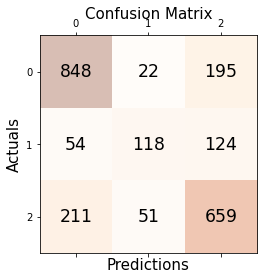

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1065
           1       0.62      0.40      0.48       296
           2       0.67      0.72      0.69       921

    accuracy                           0.71      2282
   macro avg       0.68      0.64      0.65      2282
weighted avg       0.71      0.71      0.71      2282



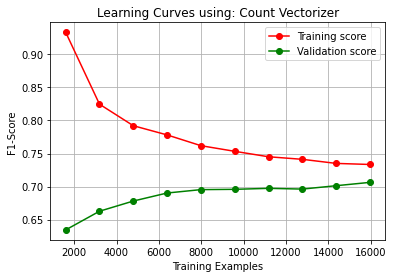

Softmax Regression using vectorizer: TF-IDF
 Accuracy: 72.52%
 f1 score: 72.20%
 Precision: 73.06%
 Recall: 72.52%


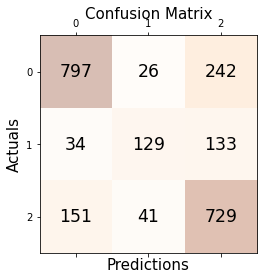

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1065
           1       0.66      0.44      0.52       296
           2       0.66      0.79      0.72       921

    accuracy                           0.73      2282
   macro avg       0.71      0.66      0.67      2282
weighted avg       0.73      0.73      0.72      2282



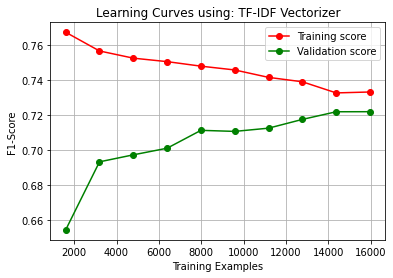

Softmax Regression using vectorizer: Hashing Vectorizer
 Accuracy: 71.21%
 f1 score: 70.34%
 Precision: 71.14%
 Recall: 71.21%


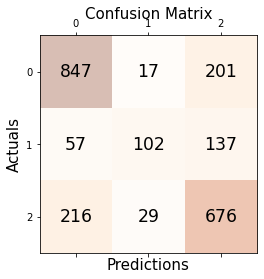

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1065
           1       0.69      0.34      0.46       296
           2       0.67      0.73      0.70       921

    accuracy                           0.71      2282
   macro avg       0.70      0.62      0.64      2282
weighted avg       0.71      0.71      0.70      2282



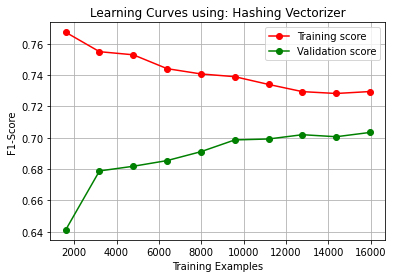

In [20]:
trainSet = pd.read_csv(train_set_location,index_col=0)  # read csv file and store it to a dataframe
validationSet = pd.read_csv(validation_set_location,index_col=0)  # read csv file and store it to a dataframe

################## TESTING PARAMETERS   ####################################################################
############################################################################################################
#pre-processing technics to be used
CLEAN_ULR_MENTIONS_NUMBERS = True   # remove urls, mentions and numbers from tweets
CLEAN_STOPWORDS = False # remove stopwords from tweets
CLEAN_EMOJIS = True # convert emojis to the equivelent text
CLEAN_PUNCUATIONS = True  # remove punctuation from tweets
CONVERT_TO_LOWERCASE = True # convert all text to lowercase
LEMMATIZATION = False # apply lemmatization to the tweets
STEMMING = False   # apply stemming to the tweets

# vectorizer parameters
MAX_FEATURES = 100000   # max features that the vetorizer will use for the vocabulary
MIN_DF = 1  # minimum frequency of every feature
MAX_DF = 1.0  # maximum frequency of every feature
N_GRAM = (1,3)  # use unigram, bigram, trigram,... for the vocabulary
N_FEATURES = 100000 # number of features created by the  Hashing Vectorizer

#SVD parameters
ENABLE_SVD = True # enable/disable decomposision with SVD for minimization of the features
N_COMPONENTS = 600   # number of features that SVD produces

# softmax parameters
SOLVER = 'newton-cg'
C_VALUE = 3
MAX_ITER = 1000
#############################################################################################################
#############################################################################################################

trainSet = trainSet.dropna()  # remove empty tweets (there are no empty tweets in the given dataset)
validationSet = validationSet.dropna()

p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.NUMBER) # set tweet-preprocessor to remove urls, mentions and numbers

def clean_tweets(data,column):  # function that removes urls, mentions and numbers from all the tweets of the given dataframe
  for i,v in enumerate(data[column]):  # for every tweet
      data.loc[i,column] = p.clean(v)
  return data

tweet_tokenizer = TweetTokenizer()   # initialize tweet tokenizer

stop_words = stopwords.words('english') # get english stop words

punctuations = list(string.punctuation) # get puncutations 
punctuations = punctuations + ['–','::','“','’','”','‘']  # add some extra puncutations
punctuations.remove('#')  # remove from puncutation
punctuations.remove('!')  # remove from puncutation
punctuations.remove('?')  # remove from puncutation 

def removeEmojis(text): # function that converts emojis to the equivalent text
    text = emoji.demojize(text) # remove emojis
    return str(text) 

def removePuncutation(text):   # remove punctuation from the given text
    text = text.replace("-","")
    splitted = tweet_tokenizer.tokenize(text) # split the tweet into tokens
    new_text = []
    for word in splitted:  # for every token
      if word not in punctuations:    # keep it only if it is not a punctuation
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def removeStopWordsAndPuncs(text):  # remove stop-words and punctuation from the given text
    text = text.replace("-","")
    splitted = tweet_tokenizer.tokenize(text)  # split the tweet into tokens
    new_text = []
    for word in splitted:   # for every token
      if word not in stop_words and word not in punctuations: # keep it only if it is not a punctuation or stop_word
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def clean(text):    # clean the given tweet
    if(CONVERT_TO_LOWERCASE): # if it is enabled
      text = text.lower()  # convert all letters in to lowercase
    if(CLEAN_EMOJIS):
      text = removeEmojis(text)  # convert all emojis to the equivelent text
    if(CLEAN_STOPWORDS and CLEAN_PUNCUATIONS):
      text = removeStopWordsAndPuncs(text)    # remove all punctuation and stopwords
    elif(CLEAN_PUNCUATIONS):
      text = removePuncutation(text)    # remove all punctuation 
    return text

def cleanText(data,column):  # apply clean function to every tweet of the given dataframe
  data[column] = data[column].apply(clean)
  return data

# stemming
ps = SnowballStemmer("english") # intialize stemmer

def stemmTweet(text): # apply stemming to the given tweet
  words = tweet_tokenizer.tokenize(text)  # split the tweet into tokens
  stemmed_text = ""
  for w in words: # for every token
    stemmed_text = stemmed_text + " "+ ps.stem(w) # stem the token
  return stemmed_text;

def stem_data(data,column): # apply stemming into every tweet of the given dataframe
  data[column] = data[column].apply(stemmTweet)
  return data

lemmatizer = nltk.stem.WordNetLemmatizer()  # initialize Lemmatizer
w_tokenizer =  TweetTokenizer() # initialize tokenizer
 
def lemmatize_text(text): # apply lemmatization to the given tweet
  return ' '.join([(lemmatizer.lemmatize(w)) for w \
                       in w_tokenizer.tokenize((text))])  # split the tweet into tokens and apply lemmatization to every token

def lemmatize_data(data,column): # apply lemmatization into every tweet of the given dataframe
  data[column] = data[column].apply(lemmatize_text)
  return data   

if(CLEAN_ULR_MENTIONS_NUMBERS):
  trainSet = clean_tweets(trainSet,'tweet') # remove urls, mentions, numbers from all the tweets in the train set
  validationSet = clean_tweets(validationSet,'tweet') # remove urls, mentions, numbers from all the tweets in the validation set
if(CLEAN_EMOJIS or CLEAN_STOPWORDS or CLEAN_PUNCUATIONS or CONVERT_TO_LOWERCASE):
  trainSet = cleanText(trainSet,'tweet')    # clean the tweets of the train set 
  validationSet = cleanText(validationSet,'tweet')    # clean the tweets of the validation set 
if(LEMMATIZATION):
  trainSet = lemmatize_data(trainSet,'tweet') # apply lemmatization to all the tweets of the train set
  validationSet = lemmatize_data(validationSet,'tweet')  # apply lemmatization to all the tweets of the validation set
if(STEMMING):
  trainSet = stem_data(trainSet,'tweet')   # apply stemming to all the tweets of the train set
  validationSet = stem_data(validationSet,'tweet')   # apply stemming to all the tweets of the validation set

X_train = list(trainSet['tweet'])  # convert the tweets of the train set into a list
y_train = list(trainSet['label'])  # convert the labels of the train set into a list

X_validation = list(validationSet['tweet'])  # convert the tweets of the validation set into a list
y_validation = list(validationSet['label'])  # convert the labels of the validation set into a list

count_vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, max_features=MAX_FEATURES,ngram_range=N_GRAM) # initialize the CountVectorizer
trainSet_transformed_countVec = count_vectorizer.fit_transform(X_train)  # run the CountVectorizer for all the tweets of the train set 
validationSet_transformed_countVec = count_vectorizer.transform(X_validation)   # transform the tweets of the validation set

tfidf_vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF,ngram_range=N_GRAM,max_features=MAX_FEATURES) #initialize the TfidfVectorizer
trainSet_transformed_tfidf = tfidf_vectorizer.fit_transform(X_train)  # run the TfidfVectorizer for all the tweets of the train set 
validationSet_transformed_tfidf = tfidf_vectorizer.transform(X_validation)    # transform the tweets of the validation set


hashing_vectorizer = HashingVectorizer(n_features=N_FEATURES,lowercase=False,ngram_range=N_GRAM)   #initialize the HashingVectorizer
trainSet_transformed_hashVec = hashing_vectorizer.fit_transform(X_train)    # run the HashingVectorizer for all the tweets of the train set 
validationSet_transformed_hashVec = hashing_vectorizer.transform(X_validation)      # transform the tweets of the validation set

if ENABLE_SVD:  # if decompisition is enabled 
  svd_countVec = TruncatedSVD(n_components=N_COMPONENTS)  # initialize SVD
  trainSet_transformed_countVec = svd_countVec.fit_transform(trainSet_transformed_countVec) # run SVD for the train set (that is already transformed from the CountVectorizer)
  validationSet_transformed_countVec = svd_countVec.transform(validationSet_transformed_countVec) # also transform the validation set 


  svd_tfidf = TruncatedSVD(n_components=N_COMPONENTS)   # initialize SVD
  trainSet_transformed_tfidf = svd_tfidf.fit_transform(trainSet_transformed_tfidf)   # run SVD for the train set (that is already transformed from the TfidfVectorizer)
  validationSet_transformed_tfidf = svd_tfidf.transform(validationSet_transformed_tfidf)   # also transform the validation set 

  svd_hashVec = TruncatedSVD(n_components=N_COMPONENTS)   # initialize SVD
  trainSet_transformed_hashVec = svd_hashVec.fit_transform(trainSet_transformed_hashVec)   # run SVD for the train set (that is already transformed from the HashingVectorizer)
  validationSet_transformed_hashVec = svd_hashVec.transform(validationSet_transformed_hashVec)   # also transform the validation set 

softmax_classifier_countVec = LogisticRegression(multi_class='multinomial', solver = SOLVER,C = C_VALUE, max_iter= MAX_ITER)   # initialize Softmax Regression for CountVectorizer
softmax_classifier_countVec.fit(trainSet_transformed_countVec, y_train)  # train softmax using the train set that was vectorized by CountVectorizer
predicted_y_countVec = softmax_classifier_countVec.predict(validationSet_transformed_countVec)    # predict the labels of the validation set 

softmax_classifier_tfidf = LogisticRegression(multi_class='multinomial', solver =SOLVER,C = C_VALUE, max_iter=MAX_ITER)  # initialize Softmax Regression for TfidfVectorizer
softmax_classifier_tfidf.fit(trainSet_transformed_tfidf, y_train)  # train softmax using the train set that was vectorized by TfidfVectorizer
predicted_y_tfidf = softmax_classifier_tfidf.predict(validationSet_transformed_tfidf)    # predict the labels of the validation set 

softmax_classifier_hashVec = LogisticRegression(multi_class='multinomial', solver =SOLVER,C = C_VALUE, max_iter=MAX_ITER)  # initialize Softmax Regression for HashingVectorizer
softmax_classifier_hashVec.fit(trainSet_transformed_hashVec, y_train)   # train softmax using the train set that was vectorized by HashingVectorizer
predicted_y_hashVec = softmax_classifier_hashVec.predict(validationSet_transformed_hashVec)   # predict the labels of the validation set 

def find_learning_curves(model,train_set,train_labels,validation_set,validation_label,modelName):  # function that creates the learning curves for the given model 
  sizes = (np.linspace(0.1, 1.0, 10)*(train_set.shape[0])).astype(int) # the size of the train set for every iteration
  validation_scores = []
  train_scores = []
  validation_mse = []
  train_mse = []
  for size in sizes:   # for every size of the training set
    new_train_set = train_set[:size]   # keep only the first (size) tweets of the train set in order to train the model
    new_train_label = train_labels[:size]   # keep only the first (size) labels of the train set
    model.fit(new_train_set,new_train_label)   # train the model with the current train size
    predictions_train = model.predict(new_train_set)   # test the model for the current train set (training score)
    f1_score_train = f1_score(new_train_label,predictions_train,average='weighted')  # compute the training score using f1 metric
    mse_train = mean_squared_error(new_train_label,predictions_train)
    train_scores.append(f1_score_train)  # store the training score
    train_mse.append(mse_train)
    predictions_validation = model.predict(validation_set)     # test the model for the whole validation set (validation score)
    f1_score_validation = f1_score(validation_label,predictions_validation,average='weighted')    # compute the validation score using f1 metric
    mse_validation = mean_squared_error(validation_label,predictions_validation)
    validation_scores.append(f1_score_validation)   # store the validation score
    validation_mse.append(mse_validation)
  # After all the iterations finish, plot the learning curves
  plt.grid()
  plt.plot(sizes, train_scores, 'o-', color="r",
            label="Training score")
  plt.plot(sizes, validation_scores, 'o-', color="g",
            label="Validation score")

  plt.legend(loc="best")
  plt.title('Learning Curves using: '+modelName)
  plt.xlabel('Training Examples')
  plt.ylabel('F1-Score')
  plt.show()


def print_report(y_validation,predicted_y,vectorizer_used):  # functions that computes scores for the given predictions and plots confusion matrix
  accuracy_countVec = accuracy_score(y_validation,predicted_y)   # accuracy metric
  f1_score_countVec = f1_score(y_validation,predicted_y,average='weighted')  # f1_score metric
  print("Softmax Regression using vectorizer: "+vectorizer_used)
  print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
  print(" f1 score: %.2f%%" %(f1_score_countVec*100))
  print(' Precision: %.2f%%' % (precision_score(y_validation, predicted_y,average='weighted')*100))  # precision
  print(' Recall: %.2f%%' % (recall_score(y_validation, predicted_y,average='weighted')*100))  # recall
  conf_matrix = confusion_matrix(y_true=y_validation, y_pred=predicted_y)
  # Print the confusion matrix using Matplotlib
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=15)
  plt.ylabel('Actuals', fontsize=15)
  plt.title('Confusion Matrix', fontsize=15)
  plt.show()

# Print report for the sotfmax that uses Count Vectorizer
print_report(y_validation,predicted_y_countVec,'Count Vectorizer')   # print metric scores and confusion matrix
print(classification_report(y_validation, predicted_y_countVec))   # print extra statistics
softmax_classifier_countVec_curves = LogisticRegression(multi_class='multinomial', solver = SOLVER,C = C_VALUE, max_iter= MAX_ITER)  # initialize a new softmax model in order to create the learning curves
find_learning_curves(softmax_classifier_countVec_curves,trainSet_transformed_countVec,y_train,validationSet_transformed_countVec,y_validation,'Count Vectorizer') # create and plot the learning curves
# Print report for the sotfmax that uses TF-IDF Vectorizer
print_report(y_validation,predicted_y_tfidf,'TF-IDF')   # print metric scores and confusion matrix
print(classification_report(y_validation, predicted_y_tfidf))      # print extra statistics
softmax_classifier_tdidf_curves = LogisticRegression(multi_class='multinomial', solver = SOLVER,C = C_VALUE, max_iter= MAX_ITER)   # initialize a new softmax model in order to create the learning curves
find_learning_curves(softmax_classifier_tdidf_curves,trainSet_transformed_tfidf,y_train,validationSet_transformed_tfidf,y_validation,'TF-IDF Vectorizer') # create and plot the learning curves
# Print report for the sotfmax that uses Hashing Vectorizer
print_report(y_validation,predicted_y_hashVec,'Hashing Vectorizer')   # print metric scores and confusion matrix
print(classification_report(y_validation, predicted_y_hashVec))    # print extra statistics
softmax_classifier_hashVec_curves = LogisticRegression(multi_class='multinomial', solver = SOLVER,C = C_VALUE, max_iter= MAX_ITER)   # initialize a new softmax model in order to create the learning curves
find_learning_curves(softmax_classifier_hashVec_curves,trainSet_transformed_hashVec,y_train,validationSet_transformed_hashVec,y_validation,'Hashing Vectorizer')  # create and plot the learning curves